In [ ]:
import sys
!{sys.executable} -m pip install deap

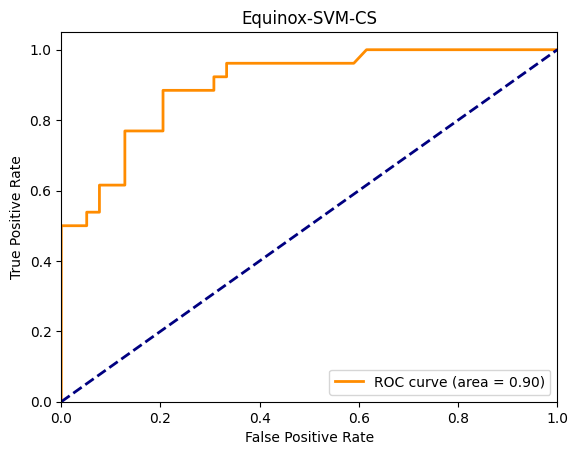

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from deap import base, creator, tools, algorithms
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
# For handling NaNs
from sklearn.impute import SimpleImputer

# Load the data
data = pd.read_csv('../equinox.csv')

# Convert 'bugs' column to binary (assuming 0 means no bug, and >0 means there's a bug)
data['bugs_binary'] = data['bugs'].apply(lambda x: 1 if x > 0 else 0)

# Pre-process the data
columns_to_drop = ['classname', 'bugs', 'nonTrivialBugs', 'majorBugs', 'criticalBugs', 'highPriorityBugs', 'bugs_binary']
X = data.drop(columns=columns_to_drop)
y = data['bugs_binary']

# Handle NaN values
X = X.dropna(axis=1, how='all')
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X))
X_imputed.columns = X.columns
X_imputed.index = X.index
X = X_imputed

# Ensure all values are non-negative
negative_features = X.columns[(X < 0).any()]
X = X.drop(columns=negative_features)

# Normalize data as chi2 requires non-negative values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# 3. Use chi-square to select the top features (for example, top 10)
X_new = SelectKBest(chi2, k=10).fit_transform(X, y)

# 4. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# 5. Train KNN
clf = SVC(probability=True)
clf.fit(X_train, y_train)

# probabilities for the positive outcome
y_pred_proba = clf.predict_proba(X_test)[:,1]
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # false positive rate and true positive rate
roc_auc = roc_auc_score(y_test, y_pred_proba)

#Save AUC values
df = pd.DataFrame({
    'AUC': roc_auc,
    'FPR': fpr,
    'TPR': tpr
})
df.to_csv('./Equinox_SVM_CS.csv', index=False)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Equinox-SVM-CS')
plt.legend(loc="lower right")
plt.show()